# Generate Figures
Author: Mark Bauer

In [1]:
# import libraries
import duckdb
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

In [2]:
# reproducibility
%reload_ext watermark
%watermark -v -p duckdb,pandas,geopandas,matplotlib,seaborn

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.6.0

duckdb    : 1.0.0
pandas    : 1.5.1
geopandas : 0.12.1
matplotlib: 3.6.2
seaborn   : 0.12.1



Note: This analysis uses the Federal Emergency Management Agency’s OpenFEMA API, but is not endorsed by FEMA. The Federal Government or FEMA cannot vouch for the data or analyses derived from these data after the data have been retrieved from the Agency's website(s).

Read more about OpenFEMA's [Terms and Conditions](https://www.fema.gov/about/openfema/terms-conditions).

# Read In Data

In [3]:
ls data/

disaster-declarations.parquet  public-assistance.parquet


In [4]:
# initiate duckdb connection
con = duckdb.connect()

# create public_assistance table
con.execute("""
    CREATE TABLE public_assistance AS
    FROM read_parquet('data/public-assistance.parquet')
"""
)

# sanity check
sql = """
    SELECT *
    FROM public_assistance
    LIMIT 10
"""

con.sql(sql)

┌────────────────┬─────────────────────┬──────────────┬───┬──────────────────────┬──────────────────────┐
│ disasterNumber │   declarationDate   │ incidentType │ … │         hash         │          id          │
│     int64      │      timestamp      │   varchar    │   │       varchar        │       varchar        │
├────────────────┼─────────────────────┼──────────────┼───┼──────────────────────┼──────────────────────┤
│           4023 │ 2011-09-02 00:00:00 │ Hurricane    │ … │ 5ff26ea21f9af4de5d…  │ d247f735-5e5d-4d47…  │
│           4155 │ 2013-11-08 00:00:00 │ Severe Storm │ … │ 39a1559d2dd1a04afa…  │ 39552c91-2dc1-4519…  │
│           4226 │ 2015-06-26 00:00:00 │ Severe Storm │ … │ aef455b4030e92d3c7…  │ d02b7bb6-fb6c-4fb4…  │
│           4314 │ 2017-05-22 00:00:00 │ Severe Storm │ … │ 727e5a2e3628d483b2…  │ 044e88f1-b38e-483c…  │
│           4337 │ 2017-09-10 00:00:00 │ Hurricane    │ … │ ab453e975b05cc1163…  │ 98731455-3b88-4fc0…  │
│           4480 │ 2020-03-20 00:00:00 │ Biolo

# Describe and Summarize Data

In [5]:
# count rows
con.sql("""
    SELECT
        COUNT(id) AS count_rows
    FROM
        public_assistance
""")

┌────────────┐
│ count_rows │
│   int64    │
├────────────┤
│     800128 │
└────────────┘

In [6]:
# examine column datatypes
con.sql("""
    SELECT
        column_name,
        column_type
    FROM
        (DESCRIBE public_assistance)
""").show(max_rows=50)

┌───────────────────────┬─────────────┐
│      column_name      │ column_type │
│        varchar        │   varchar   │
├───────────────────────┼─────────────┤
│ disasterNumber        │ BIGINT      │
│ declarationDate       │ TIMESTAMP   │
│ incidentType          │ VARCHAR     │
│ pwNumber              │ BIGINT      │
│ applicationTitle      │ VARCHAR     │
│ applicantId           │ VARCHAR     │
│ damageCategoryCode    │ VARCHAR     │
│ projectSize           │ VARCHAR     │
│ county                │ VARCHAR     │
│ countyCode            │ BIGINT      │
│ state                 │ VARCHAR     │
│ stateCode             │ VARCHAR     │
│ stateNumberCode       │ BIGINT      │
│ projectAmount         │ DOUBLE      │
│ federalShareObligated │ DOUBLE      │
│ totalObligated        │ DOUBLE      │
│ obligatedDate         │ TIMESTAMP   │
│ dcc                   │ VARCHAR     │
│ damageCategory        │ VARCHAR     │
│ lastRefresh           │ TIMESTAMP   │
│ hash                  │ VARCHAR     │


In [7]:
# summary statistics
sql = """
    SUMMARIZE
        SELECT *
        FROM public_assistance
"""

# summary statistics relation
summarize_relation = con.sql(sql)

# push to pandas df for readability
summarize_relation.df()

,column_name,column_type,min,max,approx_unique,avg,std,q25,q50,q75,count,null_percentage
0,disasterNumber,BIGINT,1239,4834,1658,2644.8032189849623,1282.3435294583735,1603,1858,4141,800128,0.00
1,declarationDate,TIMESTAMP,1998-08-26 00:00:00,2024-10-11 00:00:00,1272,None,None,None,None,None,800128,0.00
2,incidentType,VARCHAR,Biological,Winter Storm,28,None,None,None,None,None,800128,0.00
3,pwNumber,BIGINT,1,108017,20071,1652.7270811670132,2812.4249005261086,192,595,1712,800128,0.00
4,applicationTitle,VARCHAR,\t1-30 day debris removal,"¿Public Health Division 14, July 6, 2021 thru ...",531301,None,None,None,None,None,800128,0.78
5,applicantId,VARCHAR,000-00000-01,999-99999-99,67748,None,None,None,None,None,800128,0.00
6,damageCategoryCode,VARCHAR,A - Debris Removal,Z - State Management,16,None,None,None,None,None,800128,0.00
7,projectSize,VARCHAR,Large,Small,2,None,None,None,None,None,800128,1.63
8,county,VARCHAR,Abbeville,Ziebach,3561,None,None,None,None,None,800128,1.69
9,countyCode,BIGINT,0,840,333,71.84950198190873,81.78430406469928,14,54,105,800128,1.63


In [8]:
# examine NULL percentage
sql = """
    SELECT
        column_name,
        column_type,
        null_percentage
    FROM
        summarize_relation
    WHERE
        null_percentage > 0
    ORDER BY
        null_percentage DESC
"""

con.sql(sql).show(max_rows=50)

┌──────────────────┬─────────────┬─────────────────┐
│   column_name    │ column_type │ null_percentage │
│     varchar      │   varchar   │  decimal(9,2)   │
├──────────────────┼─────────────┼─────────────────┤
│ county           │ VARCHAR     │            1.69 │
│ projectSize      │ VARCHAR     │            1.63 │
│ countyCode       │ BIGINT      │            1.63 │
│ applicationTitle │ VARCHAR     │            0.78 │
└──────────────────┴─────────────┴─────────────────┘



In [9]:
# examine project amounts and obligations columns summary statistics
sql = """
    SELECT *
    FROM
        summarize_relation
    WHERE
        column_name IN (
            'projectAmount',
            'federalShareObligated',
            'totalObligated'
        )
"""

con.sql(sql).df()

,column_name,column_type,min,max,approx_unique,avg,std,q25,q50,q75,count,null_percentage
0,projectAmount,DOUBLE,-372687108.0,9053782360.01,605340,338555.8659299373,14736543.031356482,3971.5201242966973,12060.763083684411,43299.34916886018,800128,0.0
1,federalShareObligated,DOUBLE,-372687108.0,9053782360.01,627550,309817.5161233194,14495910.563616397,3146.904570774291,9693.642165026944,35107.955404167406,800128,0.0
2,totalObligated,DOUBLE,-376423296.25,9053782360.01,661149,310584.1216519717,14500259.37777791,3233.6887561916196,9928.50252720609,35756.74353101459,800128,0.0


# Preview Values

In [10]:
# preview five rows
sql = """
    SELECT *
    FROM public_assistance
    LIMIT 5   
"""

# examine first 12 columns for readability
con.sql(sql).df().iloc[:, :12]

,disasterNumber,declarationDate,incidentType,pwNumber,applicationTitle,applicantId,damageCategoryCode,projectSize,county,countyCode,state,stateCode
0,4023,2011-09-02,Hurricane,247,MCMDG00 Trumbull Ave Revetment,009-47500-00,G - Recreational or Other,Large,New Haven,9,Connecticut,CT
1,4155,2013-11-08,Severe Storm,173,SG107 - Donated Resources,093-62100-00,B - Protective Measures,Small,Meade,93,South Dakota,SD
2,4226,2015-06-26,Severe Storm,62,SCT002C - Roads and Culverts,127-99127-00,C - Roads and Bridges,Large,Scott,127,Arkansas,AR
3,4314,2017-05-22,Severe Storm,14,DUARW01 - PAAP Debris Removal 1-30 Days,051-20500-00,A - Debris Removal,Large,Holmes,51,Mississippi,MS
4,4337,2017-09-10,Hurricane,6679,Zoo Exhibit and Trail Repairs,099-UXTQE-00,"G - Parks, Recreational Facilities, and Other ...",Large,Palm Beach County,99,Florida,FL


In [11]:
# examine last 12 columns
con.sql(sql).df().iloc[:, 12:]

,stateNumberCode,projectAmount,federalShareObligated,totalObligated,obligatedDate,dcc,damageCategory,lastRefresh,hash,id
0,9,614291.00,614291.00,614291.00,2012-04-05,G,Recreational or Other,2024-03-23 17:02:09.387,5ff26ea21f9af4de5dce40c1f4ab2324b11b5fcb,d247f735-5e5d-4d47-9b4b-58a2fa6396b4
1,46,20739.92,16506.90,16506.90,2024-03-22,B,Protective Measures,2024-03-23 17:02:09.387,39a1559d2dd1a04afafdcde601838082c65b4729,39552c91-2dc1-4519-87fb-b6beb815a0ad
2,5,205754.79,154316.09,154316.09,2015-12-08,C,Roads and Bridges,2024-03-23 17:02:09.387,aef455b4030e92d3c7219138d3456fcebdd789bf,d02b7bb6-fb6c-4fb4-a029-58fdfc9848f9
3,28,2115399.61,1687334.81,1687334.81,2017-07-21,A,Debris Removal,2024-03-23 17:02:09.387,727e5a2e3628d483b2ac6407f48663a3a69a144e,044e88f1-b38e-483c-b579-80a60c6a10fa
4,12,137858.93,124077.54,124077.54,2020-01-24,G,"Parks, Recreational Facilities, and Other Items",2024-09-06 15:04:53.183,ab453e975b05cc11633455ccde7607fdd24ff1ca,98731455-3b88-4fc0-af7f-dae089378537


In [12]:
# examine last refreshed
sql = """
    SELECT
        lastRefresh
    FROM
        public_assistance
    ORDER BY
        lastRefresh DESC
    LIMIT 1  
"""

con.sql(sql).df()

,lastRefresh
0,2024-10-20 15:05:23.895


These tables and figures are based on the date above.

# Figures and Tables

**Table xx.** Top 20 Public Assistance Projects by Highest Total Obligated Amount (Millions)

In [13]:
sql = """
    WITH disasters_table AS (
        SELECT
            disasterNumber,
            state,
            strftime(declarationDate, '%Y')::INT AS year,
            incidentType,
            ROUND(SUM(totalObligated) / 1_000_000, 0)::INT AS totalObligatedM
        FROM
            public_assistance
        GROUP BY ALL
        ORDER BY
            totalObligatedM DESC
        LIMIT 20
    )
    
    SELECT
        row_number() OVER () AS rank,
        *
    FROM
        disasters_table
            
"""

disasters_df = con.sql(sql).df()

# sanity check
print(disasters_df.shape)
disasters_df.style.hide(axis="index")

(20, 6)


rank,disasterNumber,state,year,incidentType,totalObligatedM
1,4339,Puerto Rico,2017,Hurricane,34219
2,4480,New York,2020,Biological,15622
3,4340,Virgin Islands,2017,Hurricane,15613
4,4485,Texas,2020,Biological,14931
5,4085,New York,2012,Hurricane,14735
6,1603,Louisiana,2005,Hurricane,13666
7,4482,California,2020,Biological,11859
8,1391,New York,2001,Fire,4733
9,4486,Florida,2020,Biological,3705
10,1604,Mississippi,2005,Hurricane,3219


In [14]:
# markdown for GitHub
print(disasters_df.to_markdown(index=False))

|   rank |   disasterNumber | state          |   year | incidentType   |   totalObligatedM |
|-------:|-----------------:|:---------------|-------:|:---------------|------------------:|
|      1 |             4339 | Puerto Rico    |   2017 | Hurricane      |             34219 |
|      2 |             4480 | New York       |   2020 | Biological     |             15622 |
|      3 |             4340 | Virgin Islands |   2017 | Hurricane      |             15613 |
|      4 |             4485 | Texas          |   2020 | Biological     |             14931 |
|      5 |             4085 | New York       |   2012 | Hurricane      |             14735 |
|      6 |             1603 | Louisiana      |   2005 | Hurricane      |             13666 |
|      7 |             4482 | California     |   2020 | Biological     |             11859 |
|      8 |             1391 | New York       |   2001 | Fire           |              4733 |
|      9 |             4486 | Florida        |   2020 | Biological    

**Table xx.** Top 20 Public Assistance Project by Highest Total Obligated Amount per Incident Type (Millions)

In [15]:
sql = """
    SELECT
        DISTINCT ON (incidentType)
        disasterNumber,
        state,
        strftime(declarationDate, '%Y')::INT AS year,
        incidentType,
        SUM(totalObligated) AS totalObligated
    FROM
        public_assistance
    GROUP BY ALL
    ORDER BY
        totalObligated DESC
"""

relation = con.sql(sql).df()

disasters_df = con.sql("""
    SELECT
        incidentType,
        disasterNumber,
        state,
        year,
        ROUND(totalObligated / 1_000_000, 2) AS totalObligatedM
    FROM
        relation
    ORDER BY
        incidentType ASC
""").df()

print(disasters_df.shape)
disasters_df

(28, 5)


,incidentType,disasterNumber,state,year,totalObligatedM
0,Biological,4480,New York,2020,15621.95
1,Chemical,3366,West Virginia,2014,1.64
2,Coastal Storm,1379,Texas,2001,433.65
3,Dam/Levee Break,1529,California,2004,21.03
4,Drought,3276,Federated States of Micronesia,2007,0.08
5,Earthquake,4473,Puerto Rico,2020,948.42
6,Fire,1391,New York,2001,4732.56
7,Flood,4308,California,2017,820.38
8,Freezing,1468,Maine,2003,1.74
9,Hurricane,4339,Puerto Rico,2017,34219.01


In [16]:
# markdown for GitHub
print(disasters_df.to_markdown(index=False))

| incidentType                    |   disasterNumber | state                          |   year |   totalObligatedM |
|:--------------------------------|-----------------:|:-------------------------------|-------:|------------------:|
| Biological                      |             4480 | New York                       |   2020 |          15622    |
| Chemical                        |             3366 | West Virginia                  |   2014 |              1.64 |
| Coastal Storm                   |             1379 | Texas                          |   2001 |            433.65 |
| Dam/Levee Break                 |             1529 | California                     |   2004 |             21.03 |
| Drought                         |             3276 | Federated States of Micronesia |   2007 |              0.08 |
| Earthquake                      |             4473 | Puerto Rico                    |   2020 |            948.42 |
| Fire                            |             1391 | New York 

In [17]:
sql = """
    SELECT
        strftime(declarationDate, '%Y')::INT AS year,
        SUM(totalObligated) AS totalObligated,
        ROUND(SUM(totalObligated) / 1_000_000)::INT AS totalObligatedM
    FROM
        public_assistance
    GROUP BY
        year
    ORDER BY
        totalObligatedM DESC
"""

year_incident_df = con.sql(sql).df()

# sanity check
print(year_incident_df.shape)
year_incident_df.head()

(27, 3)


,year,totalObligated,totalObligatedM
0,2020,9.345711e+10,93457
1,2017,5.781501e+10,57815
2,2005,2.150929e+10,21509
3,2012,1.788338e+10,17883
4,2018,6.345451e+09,6345


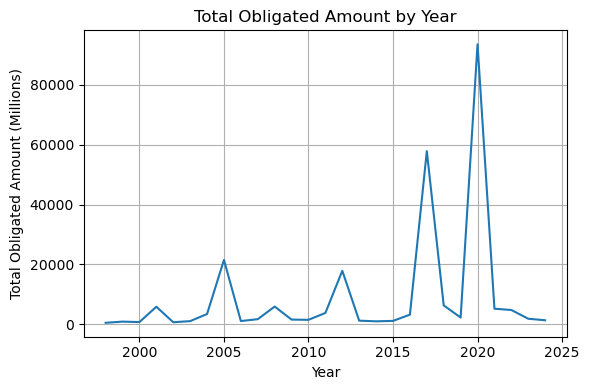

In [18]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.lineplot(
    data=year_incident_df,
    x='year',
    y='totalObligatedM',
    ax=ax
)

plt.title("Total Obligated Amount by Year")
plt.xlabel("Year")
plt.ylabel("Total Obligated Amount (Millions)")
plt.grid(True)

plt.tight_layout()

In [19]:
sql = """
    SELECT
        incidentType,
        SUM(totalObligated) AS totalObligated,
        SUM(totalObligated) / 1_000_000 AS totalObligatedM
    FROM
        public_assistance
    GROUP BY 1
    ORDER BY
        totalObligatedM DESC
    LIMIT 10
"""

incident_df = con.sql(sql).df()

# sanity check
print(incident_df.shape)
incident_df.head()

(10, 3)


,incidentType,totalObligated,totalObligatedM
0,Hurricane,1.188915e+11,118891.490099
1,Biological,8.575151e+10,85751.511508
2,Severe Storm,1.321390e+10,13213.898531
3,Fire,6.998937e+09,6998.936653
4,Flood,5.843293e+09,5843.293434


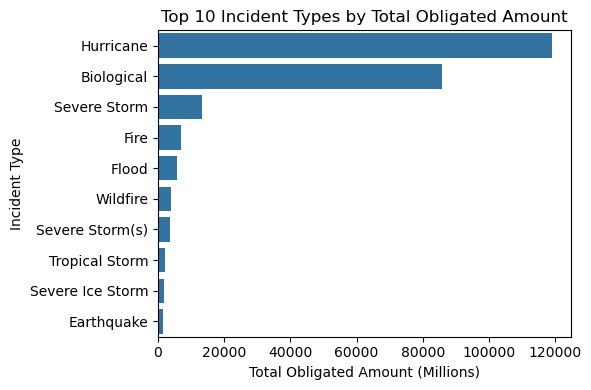

In [20]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.barplot(
    data=incident_df,
    y='incidentType',
    x='totalObligatedM',
    color="C0",
    ax=ax
)

plt.title("Top 10 Incident Types by Total Obligated Amount")
plt.ylabel("Incident Type")
plt.xlabel("Total Obligated Amount (Millions)")

plt.tight_layout()

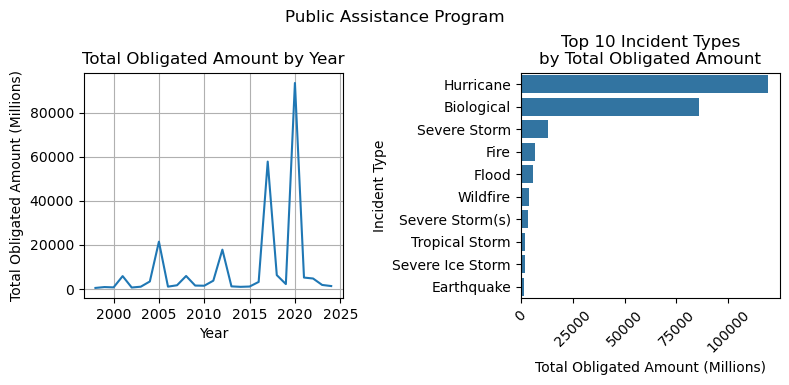

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

sns.lineplot(
    data=year_incident_df,
    x='year',
    y='totalObligatedM',
    ax=axs[0]
)

axs[0].set_title("Total Obligated Amount by Year")
axs[0].set_xlabel("Year")
axs[0].set_ylabel("Total Obligated Amount (Millions)")
axs[0].grid(True)

sns.barplot(
    data=incident_df,
    y='incidentType',
    x='totalObligatedM',
    color="C0",
    ax=axs[1]
)

axs[1].set_title("Top 10 Incident Types\nby Total Obligated Amount")
axs[1].set_ylabel("Incident Type")
axs[1].set_xlabel("Total Obligated Amount (Millions)")
axs[1].tick_params(axis='x', labelrotation = 45)

plt.suptitle('Public Assistance Program', y=.95)
plt.tight_layout()
plt.savefig('figures/year-incident.png', dpi=200, bbox_inches='tight')

In [22]:
sql = """
    SELECT
        state,
        SUM(totalObligated) AS totalObligated,
        SUM(totalObligated) / 1_000_000 AS totalObligatedM
    FROM
        public_assistance
    GROUP BY
        state
    ORDER BY
        totalObligatedM DESC
    LIMIT 20
"""

state_df = con.sql(sql).df()

# sanity check
print(state_df.shape)
state_df.head()

(20, 3)


,state,totalObligated,totalObligatedM
0,New York,3.846188e+10,38461.883368
1,Puerto Rico,3.729983e+10,37299.833828
2,Louisiana,2.506915e+10,25069.153258
3,Texas,2.272723e+10,22727.231491
4,California,1.833737e+10,18337.370841


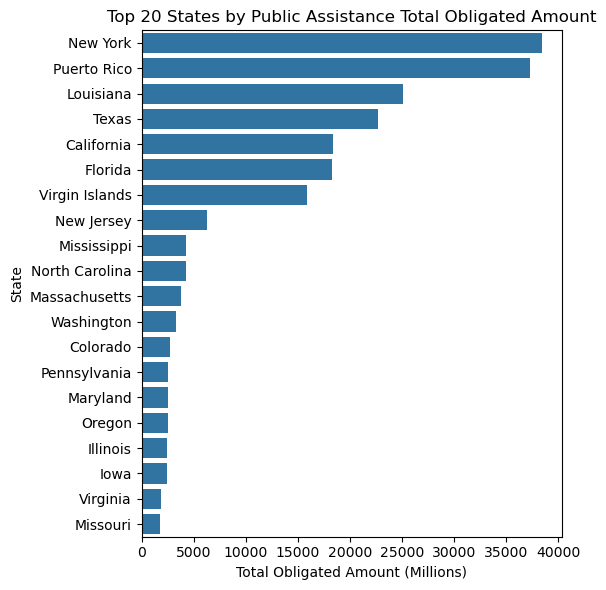

In [23]:
fig, ax = plt.subplots(figsize=(6, 6))

sns.barplot(
    data=state_df,
    y='state',
    x='totalObligatedM',
    color="C0",
    ax=ax
)

plt.title("Top 20 States by Public Assistance Total Obligated Amount")
plt.ylabel("State")
plt.xlabel("Total Obligated Amount (Millions)")

plt.tight_layout()

In [24]:
sql = """
    SELECT
        incidentType,
        state,
        SUM(totalObligated) AS totalObligated,
        SUM(totalObligated) / 1_000_000 AS totalObligatedM
    FROM
        public_assistance
    GROUP BY
        1, 2
    ORDER BY
        totalObligatedM DESC
"""

incident_state_df = con.sql(sql).df()

# sanity check
print(incident_state_df.shape)
incident_state_df.head()

(443, 4)


,incidentType,state,totalObligated,totalObligatedM
0,Hurricane,Puerto Rico,3.603843e+10,36038.427327
1,Hurricane,Louisiana,2.147500e+10,21475.003562
2,Hurricane,Virgin Islands,1.568048e+10,15680.481937
3,Biological,New York,1.562551e+10,15625.510704
4,Hurricane,New York,1.534271e+10,15342.708357


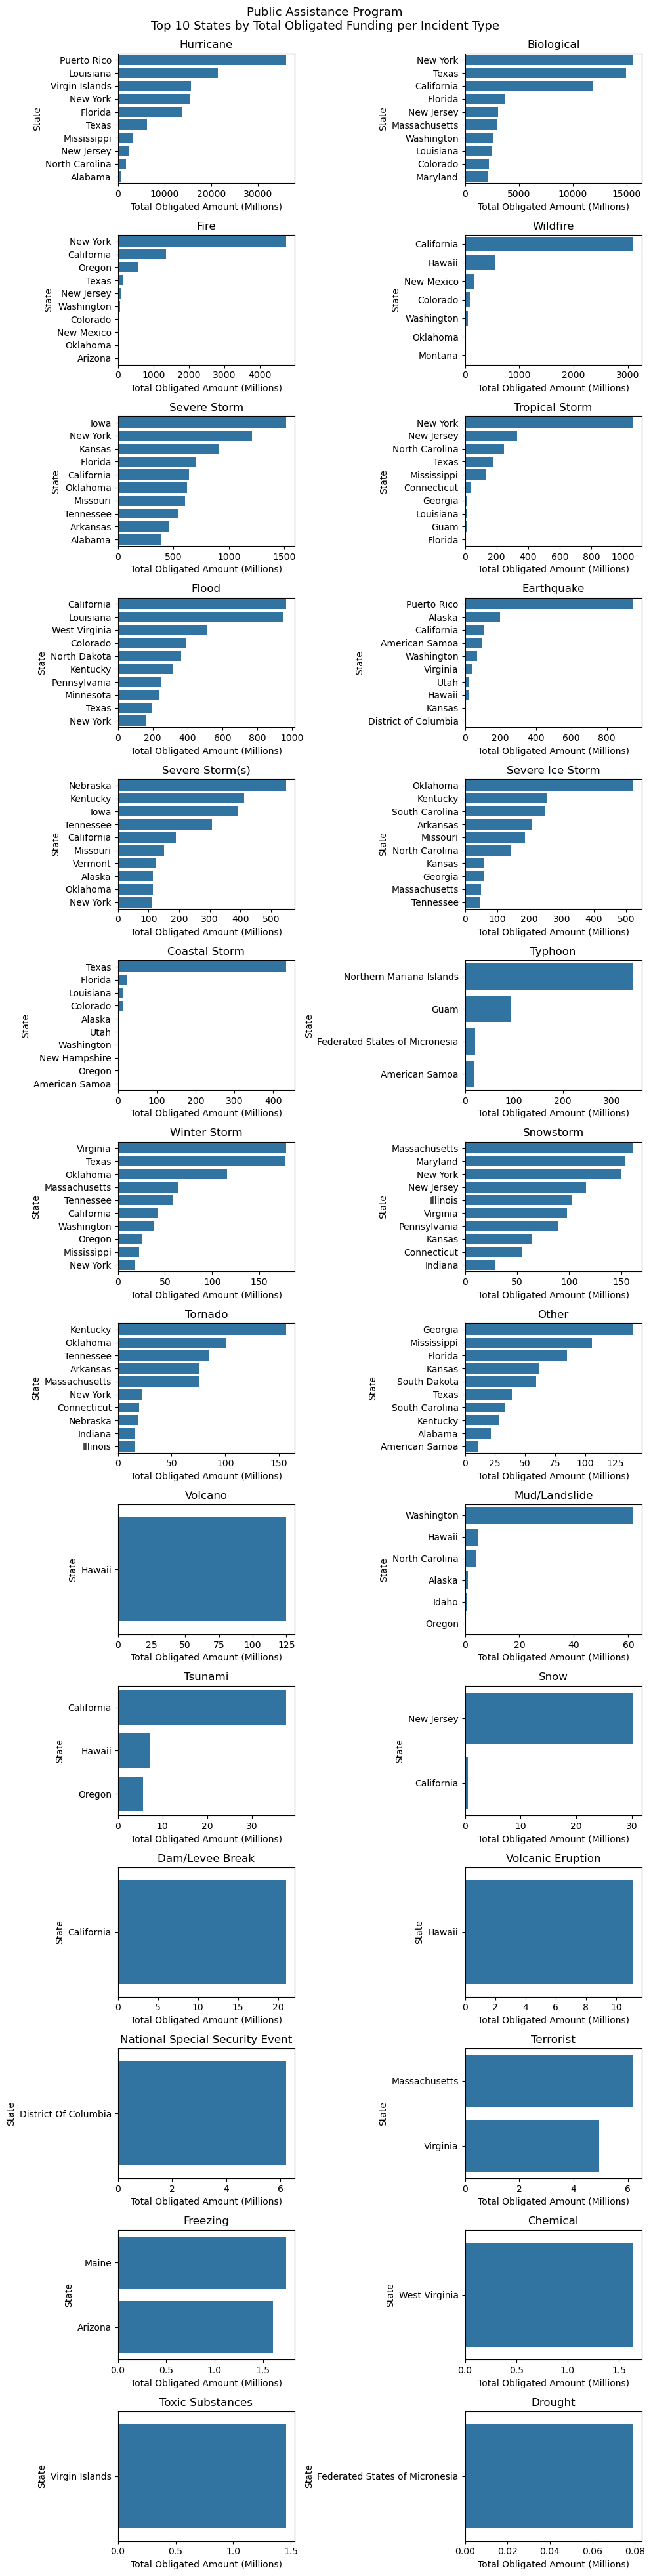

In [25]:
# return list of unique incident types
incidents = incident_state_df['incidentType'].unique()

# create figure with 14 rows and 2 columns
fig, axs = plt.subplots(14, 2, figsize=(10, 40))
    
# loop through both incident and axis    
for incident, ax in zip(incidents, axs.flat):
    
    # return dataframe based on incident type
    bar = (
        incident_state_df
        .loc[incident_state_df['incidentType'] == incident]
        .sort_values(by='totalObligatedM', ascending=False)
        .head(10)
    )
    
    # plot incident bar chart
    sns.barplot(
        data=bar,
        y='state',
        x='totalObligatedM',
        color="C0",
        ax=ax
    )
    
    # axis aesthetics
    ax.set_title(incident)
    ax.set_xlabel('Total Obligated Amount (Millions)')
    ax.set_ylabel('State')
    
# add figure title
suptitle = 'Public Assistance Program\nTop 10 States by \
Total Obligated Funding per Incident Type\n\n\n'    
plt.suptitle(suptitle, fontsize=13)  

# tight layout and save figure
fig.tight_layout()
fig.savefig('figures/incident-state.png', dpi=200, bbox_inches='tight')   

# Maps

In [26]:
sql = """
    SELECT
        stateCode,
        SUM(totalObligated) AS totalObligated,
        SUM(totalObligated) / 1_000_000 AS totalObligatedM
    FROM
        public_assistance
    GROUP BY
        stateCode
    ORDER BY
        totalObligated DESC
"""

state_df = con.sql(sql).df()

# sanity check
print(state_df.shape)
state_df.head()

(61, 3)


,stateCode,totalObligated,totalObligatedM
0,NY,3.846188e+10,38461.883368
1,PR,3.729983e+10,37299.833828
2,LA,2.506915e+10,25069.153258
3,TX,2.272723e+10,22727.231491
4,CA,1.833737e+10,18337.370841


Retrieve US shapefile: https://catalog.data.gov/dataset/tiger-line-shapefile-current-nation-u-s-state-and-equivalent-entities

In [27]:
# read states shapefile
path = 'https://www2.census.gov/geo/tiger/TIGER2023/STATE/tl_2023_us_state.zip'
states_gdf = gpd.read_file(path)

# sanity check
print(states_gdf.shape)
states_gdf.head()

(56, 16)


,REGION,DIVISION,STATEFP,STATENS,GEOID,GEOIDFQ,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,3,5,54,01779805,54,0400000US54,WV,West Virginia,00,G4000,A,62266499712,489003081,+38.6472854,-080.6183274,"POLYGON ((-77.75438 39.33346, -77.75422 39.333..."
1,3,5,12,00294478,12,0400000US12,FL,Florida,00,G4000,A,138963763779,45970528648,+28.3989775,-082.5143005,"MULTIPOLYGON (((-83.10874 24.62949, -83.10711 ..."
2,2,3,17,01779784,17,0400000US17,IL,Illinois,00,G4000,A,143778366814,6216688589,+40.1028754,-089.1526108,"POLYGON ((-87.89243 38.28285, -87.89334 38.282..."
3,2,4,27,00662849,27,0400000US27,MN,Minnesota,00,G4000,A,206244555303,18937471947,+46.3159573,-094.1996043,"POLYGON ((-95.31991 48.99892, -95.31778 48.998..."
4,3,5,24,01714934,24,0400000US24,MD,Maryland,00,G4000,A,25151736098,6979330958,+38.9466584,-076.6744939,"POLYGON ((-75.75600 39.24607, -75.75579 39.243..."


In [28]:
# identify CRS
states_gdf.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [29]:
# merge public assistance dollars to state boundaries
states_merged = states_gdf.merge(
    state_df,
    left_on='STUSPS',
    right_on='stateCode',
    how='left'
)

# sanity check
states_merged.head()

,REGION,DIVISION,STATEFP,STATENS,GEOID,GEOIDFQ,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,stateCode,totalObligated,totalObligatedM
0,3,5,54,01779805,54,0400000US54,WV,West Virginia,00,G4000,A,62266499712,489003081,+38.6472854,-080.6183274,"POLYGON ((-77.75438 39.33346, -77.75422 39.333...",WV,9.840855e+08,984.085480
1,3,5,12,00294478,12,0400000US12,FL,Florida,00,G4000,A,138963763779,45970528648,+28.3989775,-082.5143005,"MULTIPOLYGON (((-83.10874 24.62949, -83.10711 ...",FL,1.827646e+10,18276.456437
2,2,3,17,01779784,17,0400000US17,IL,Illinois,00,G4000,A,143778366814,6216688589,+40.1028754,-089.1526108,"POLYGON ((-87.89243 38.28285, -87.89334 38.282...",IL,2.456597e+09,2456.596900
3,2,4,27,00662849,27,0400000US27,MN,Minnesota,00,G4000,A,206244555303,18937471947,+46.3159573,-094.1996043,"POLYGON ((-95.31991 48.99892, -95.31778 48.998...",MN,1.099611e+09,1099.611379
4,3,5,24,01714934,24,0400000US24,MD,Maryland,00,G4000,A,25151736098,6979330958,+38.9466584,-076.6744939,"POLYGON ((-75.75600 39.24607, -75.75579 39.243...",MD,2.534982e+09,2534.982259


In [30]:
# examine NULLS count
states_merged.loc[states_merged['stateCode'].isnull()]

,REGION,DIVISION,STATEFP,STATENS,GEOID,GEOIDFQ,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,stateCode,totalObligated,totalObligatedM


In [31]:
# calculate total obligation dollars per kilometer
# convert land area (sq meters) to sq kilometers
states_merged['totalObligatedkm'] = states_merged['totalObligated'] / (states_merged['ALAND'] / 1_000_000)

states_merged.head().iloc[:, -4:]

,stateCode,totalObligated,totalObligatedM,totalObligatedkm
0,WV,9.840855e+08,984.085480,15804.413035
1,FL,1.827646e+10,18276.456437,131519.584243
2,IL,2.456597e+09,2456.596900,17085.998081
3,MN,1.099611e+09,1099.611379,5331.589858
4,MD,2.534982e+09,2534.982259,100787.565889


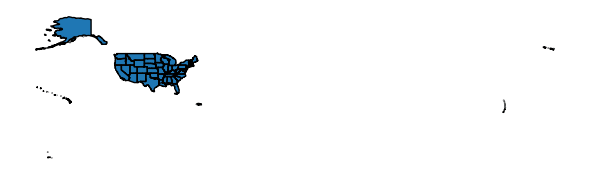

In [32]:
# sanity check map
fig, ax = plt.subplots(figsize=(6, 6))

states_merged.plot(ax=ax)

states_gdf.plot(
    ax=ax,
    facecolor='none', 
    edgecolor='black', 
    zorder=1
)

plt.axis('off')
plt.tight_layout()

In [33]:
# locate conus only gdf
conus_gdf = states_merged.loc[
    (states_merged['GEOID'].astype(int) <= 56)
    & (~states_merged['GEOID'].isin(['02', '15']))
]

# transform CRS
conus_gdf = conus_gdf.to_crs(5070)

conus_gdf.head()

,REGION,DIVISION,STATEFP,STATENS,GEOID,GEOIDFQ,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,stateCode,totalObligated,totalObligatedM,totalObligatedkm
0,3,5,54,01779805,54,0400000US54,WV,West Virginia,00,G4000,A,62266499712,489003081,+38.6472854,-080.6183274,"POLYGON ((1548777.304 1961418.875, 1548791.323...",WV,9.840855e+08,984.085480,15804.413035
1,3,5,12,00294478,12,0400000US12,FL,Florida,00,G4000,A,138963763779,45970528648,+28.3989775,-082.5143005,"MULTIPOLYGON (((1318717.052 267177.248, 131868...",FL,1.827646e+10,18276.456437,131519.584243
2,2,3,17,01779784,17,0400000US17,IL,Illinois,00,G4000,A,143778366814,6216688589,+40.1028754,-089.1526108,"POLYGON ((701650.471 1724476.457, 701575.841 1...",IL,2.456597e+09,2456.596900,17085.998081
3,2,4,27,00662849,27,0400000US27,MN,Minnesota,00,G4000,A,206244555303,18937471947,+46.3159573,-094.1996043,"POLYGON ((50386.396 2888284.096, 50544.128 288...",MN,1.099611e+09,1099.611379,5331.589858
4,3,5,24,01714934,24,0400000US24,MD,Maryland,00,G4000,A,25151736098,6979330958,+38.9466584,-076.6744939,"POLYGON ((1718035.440 1986172.419, 1718118.217...",MD,2.534982e+09,2534.982259,100787.565889


In [34]:
# identify bounds of map
conus_gdf['totalObligatedM'].describe()

count       49.000000
mean      3926.198486
std       7525.273950
min         20.382427
25%        902.578793
50%       1301.864916
75%       2534.982259
max      38461.883368
Name: totalObligatedM, dtype: float64

/var/folders/2_/t32jmn4n7cs9v7ll96cqlmn00000gn/T/ipykernel_37801/3060095120.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


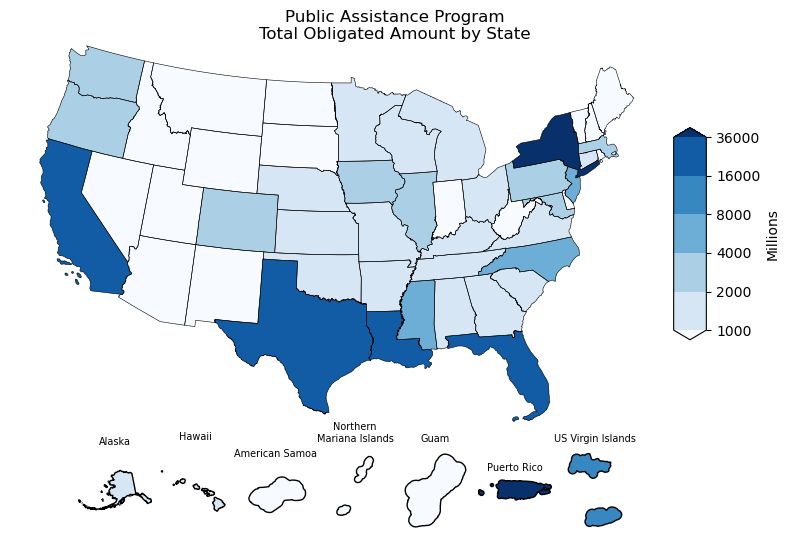

In [35]:
fig, ax = plt.subplots(figsize=(8, 8))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cmap = plt.cm.Blues
norm = mpl.colors.BoundaryNorm(
    [1000, 2000, 4000, 8000, 16000, 36000],
    cmap.N,
    extend='both'
)

# plot conus values
conus_gdf.plot(
    column='totalObligatedM',
    legend=True,
    cmap=cmap,
    cax=cax,
    norm=norm,
    ax=ax,
)

# plot conus shapes
conus_gdf.plot(
    ax=ax,
    zorder=1,
    facecolor='None',
    linewidth=.4,
)

# add axes for non-conus states
alaska = fig.add_axes([.10, 0.1, 0.1, 0.1])
hawaii = fig.add_axes([.20, 0.1, 0.1, 0.1])
ams = fig.add_axes([.30, 0.1, 0.1, 0.1])
mp = fig.add_axes([.40, 0.1, 0.1, 0.1])
gu = fig.add_axes([.50, 0.1, 0.1, 0.1])
pr = fig.add_axes([.60, 0.1, 0.1, 0.1])
vi = fig.add_axes([.70, 0.1, 0.1, 0.1])

# function to plot non-conus states
def plot_states(geoid, crs, ax, title):
    (states_merged
    .loc[states_merged['GEOID'].isin([geoid])]
    .to_crs(crs)
    .plot(
        column='totalObligatedM',
        legend=True,
        cmap=cmap,
        cax=cax,
        norm=norm,
        ax=ax,
        edgecolor='black'
    )
    .set_title(title, fontsize=7)
    )
    
# plot non-conus states    
plot_states('02', 3338, alaska, 'Alaska')   
plot_states('15', 3760, hawaii, 'Hawaii')  
plot_states('60', 3102, ams, 'American Samoa')  
plot_states('69', 3993, mp, 'Northern\nMariana Islands')
plot_states('66', 3993, gu, 'Guam') 
plot_states('72', 4326, pr, 'Puerto Rico')  
plot_states('78', 3991, vi, 'US Virgin Islands') 
  
# axis aesthetics
ax.axis('off')
ams.axis('off')
ams.set_xlim(left=150_000, right=350_000)
ams.set_ylim(bottom=250_000, top=375_000)
gu.axis('off')
mp.axis('off')
mp.set_ylim(bottom=None, top=275_000)
pr.axis('off')
vi.axis('off')
hawaii.axis('off')
hawaii.set_xlim(50000)
hawaii.set_ylim(bottom=None, top=1000000)
alaska.axis('off')

cax.set_ylabel('Millions')

fig.suptitle('Public Assistance Program\nTotal Obligated Amount by State', y=.75)
fig.tight_layout()
fig.savefig('figures/total-obligated-map.png', dpi=200, bbox_inches='tight')

In [36]:
# identify map bounds
conus_gdf['totalObligatedkm'].describe()

count    4.900000e+01
mean     1.907466e+05
std      1.002684e+06
min      8.105693e+01
25%      6.387898e+03
50%      1.424125e+04
75%      3.532904e+04
max      7.041320e+06
Name: totalObligatedkm, dtype: float64

/var/folders/2_/t32jmn4n7cs9v7ll96cqlmn00000gn/T/ipykernel_37801/3780557181.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


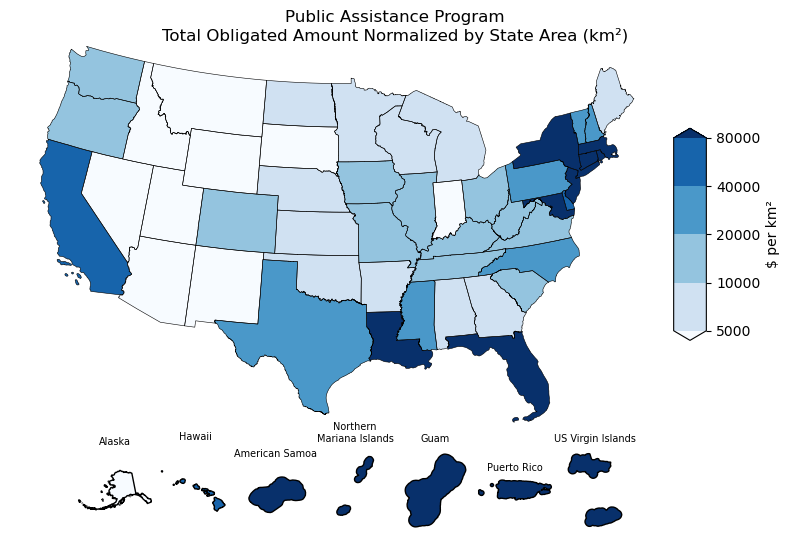

In [37]:
fig, ax = plt.subplots(figsize=(8, 8))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cmap = plt.cm.Blues
norm = mpl.colors.BoundaryNorm(
    [5_000, 10_000, 20_000, 40_000, 80_000],
    cmap.N,
    extend='both'
)

conus_gdf.plot(
    column='totalObligatedkm',
    legend=True,
    cmap=cmap,
    cax=cax,
    norm=norm,
    ax=ax
)

conus_gdf.plot(
    ax=ax,
    zorder=1,
    facecolor='None',
    linewidth=.4,
)

alaska = fig.add_axes([.10, 0.1, 0.1, 0.1])
hawaii = fig.add_axes([.20, 0.1, 0.1, 0.1])
ams = fig.add_axes([.30, 0.1, 0.1, 0.1])
mp = fig.add_axes([.40, 0.1, 0.1, 0.1])
gu = fig.add_axes([.50, 0.1, 0.1, 0.1])
pr = fig.add_axes([.60, 0.1, 0.1, 0.1])
vi = fig.add_axes([.70, 0.1, 0.1, 0.1])

def plot_states(geoid, crs, ax, title):
    (states_merged
    .loc[states_merged['GEOID'].isin([geoid])]
    .to_crs(crs)
    .plot(
        column='totalObligatedkm',
        legend=True,
        cmap=cmap,
        cax=cax,
        norm=norm,
        ax=ax,
        edgecolor='black'
    )
    .set_title(title, fontsize=7)
    )
    
plot_states('02', 3338, alaska, 'Alaska')   
plot_states('15', 3760, hawaii, 'Hawaii')  
plot_states('60', 3102, ams, 'American Samoa')  
plot_states('69', 3993, mp, 'Northern\nMariana Islands')
plot_states('66', 3993, gu, 'Guam') 
plot_states('72', 4326, pr, 'Puerto Rico')  
plot_states('78', 3991, vi, 'US Virgin Islands') 
  
ax.axis('off')
ams.axis('off')
ams.set_xlim(left=150_000, right=350_000)
ams.set_ylim(bottom=250_000, top=375_000)
gu.axis('off')
mp.axis('off')
mp.set_ylim(bottom=None, top=275_000)
pr.axis('off')
vi.axis('off')
hawaii.axis('off')
hawaii.set_xlim(50000)
hawaii.set_ylim(bottom=None, top=1000000)
alaska.axis('off')

cax.set_ylabel('$ per km\u00B2')

fig.suptitle('Public Assistance Program\nTotal Obligated Amount Normalized by State Area (km\u00B2)', y=.75)
fig.tight_layout()
fig.savefig('figures/total-obligated-normalized-map.png', dpi=200, bbox_inches='tight')